# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:

from numpy.random import RandomState 
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

In [2]:
COUNT_SCOUT = 500
COUNT_BEST = 200
BUDGET = 10_000_000_000
INCOME_BARREL = 450000
PROB_LOSSES = 0.025

## Загрузка и подготовка данных

### Загрузка и предварительный анализ данных

<div style="border: 5px solid violet; border-radius: 5px;">
Начнём анализ данных и их подготовку с одного датасета и по аналогии сделаем остальные.
</div>

ОФФТОП: первый раз фиолетовым выделяю, также первый раз до ревью выделяю комменты, незнаю как будет смотреться, но думаю будет выделяться. Все остальные цвета заняты)

In [3]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [4]:
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


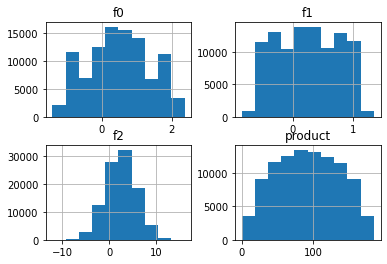

In [6]:
geo_0.hist();

In [7]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
geo_0['id'].unique().shape

(99990,)

In [9]:
geo_0.duplicated().sum()

0

<div style="border: 5px solid violet; border-radius: 5px;">
Данные пропусков не имеют. Все столбцы приведены к нужным типам. Судя по гистограмме выбросов, аномалий нет, похоже чем-то на нормальное распределение. describe ничего не дало - потому что признаки зашифрованы, будем игнорировать.
Есть дубликаты в id скважин, но явных дубликатов нет - поэтому 10 строками мы пренебрежем.    
</div>

In [10]:
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [11]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


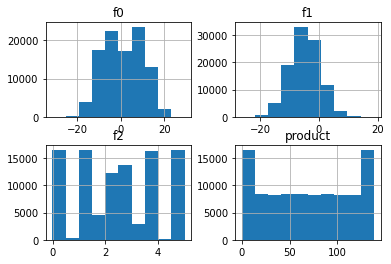

In [13]:
geo_1.hist();

In [14]:
geo_1['id'].unique().shape

(99996,)

In [15]:
geo_1.duplicated().sum()

0

In [16]:
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [17]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [18]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


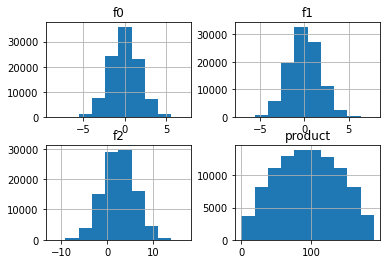

In [19]:
geo_2.hist();

In [20]:
geo_2['id'].unique().shape

(99996,)

In [21]:
geo_2.duplicated().sum()

0

<div style="border: 5px solid violet; border-radius: 5px;">
Всё практически аналогично с первым датасетом. Самое главное - правильные типы столбцов и отсутствие пропусков.

Есть интересные закономерности на гистограммах во втором датасете, но исследовать мы это не будем. Пока что. 
</div>

In [22]:
geo_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [23]:
geo_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [24]:
geo_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [25]:
geo_1['product'].unique().shape

(12,)

In [26]:
geo_1['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [27]:
geo_1['f2'].unique().shape

(100000,)

### Деление данных

In [28]:
geo_0_features = geo_0.drop(['id', 'product'], axis=1)
geo_0_target = geo_0['product']
print(geo_0_features)
print(geo_0_target)

             f0        f1        f2
0      0.705745 -0.497823  1.221170
1      1.334711 -0.340164  4.365080
2      1.022732  0.151990  1.419926
3     -0.032172  0.139033  2.978566
4      1.988431  0.155413  4.751769
...         ...       ...       ...
99995  0.971957  0.370953  6.075346
99996  1.392429 -0.382606  1.273912
99997  1.029585  0.018787 -1.348308
99998  0.998163 -0.528582  1.583869
99999  1.764754 -0.266417  5.722849

[100000 rows x 3 columns]
0        105.280062
1         73.037750
2         85.265647
3        168.620776
4        154.036647
            ...    
99995    110.744026
99996    122.346843
99997     64.375443
99998     74.040764
99999    149.633246
Name: product, Length: 100000, dtype: float64


In [29]:
geo_1_features = geo_1.drop(['id', 'product'], axis=1)
geo_1_target = geo_1['product']

In [30]:
geo_2_features = geo_2.drop(['id', 'product'], axis=1)
geo_2_target = geo_2['product']

In [31]:
geo_0_features_train, geo_0_features_valid, geo_0_target_train, geo_0_target_valid = (train_test_split(geo_0_features,
                                                                                                       geo_0_target,
                                                                                                       test_size=0.25,
                                                                                                       random_state=12345)
)
print(geo_0_features_train.shape)
print(geo_0_target_train.shape)
print(geo_0_features_valid.shape)
print(geo_0_target_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [32]:
geo_1_features_train, geo_1_features_valid, geo_1_target_train, geo_1_target_valid = (train_test_split(geo_1_features,
                                                                                                       geo_1_target,
                                                                                                       test_size=0.25,
                                                                                                       random_state=12345)
)
print(geo_1_features_train.shape)
print(geo_1_target_train.shape)
print(geo_1_features_valid.shape)
print(geo_1_target_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [33]:
geo_2_features_train, geo_2_features_valid, geo_2_target_train, geo_2_target_valid = (train_test_split(geo_2_features,
                                                                                                       geo_2_target,
                                                                                                       test_size=0.25,
                                                                                                       random_state=12345)
)
print(geo_2_features_train.shape)
print(geo_2_target_train.shape)
print(geo_2_features_valid.shape)
print(geo_2_target_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


<div style="border: 5px solid violet; border-radius: 5px;">
Из признаков, помимо целевого признака, также удалили столбец с id. Он бесполезен, возможно, даже будет мешать.

    
В задании сказано, что нужно обучить модель для каждого региона. Старшие коллеги и коллеги в обсуждении упомянули, что тоже лучше для каждого регионга своя модель, так как у каждого могут быть свои особенности. Поэтому у нас 3 набора данных. 
    
Делили без тестовой в соотношении 3:1.
</div>

### Масштабирование

<div style="border: 5px solid violet; border-radius: 5px;">
Данные практически готовы к анализу. 

Сделаем только всё таки масштабирование, потому что в некоторых датасетах - разница в 4-5 раз между величинами.

Также для каждого региона будет своё масштабирование.
</div>

In [34]:
numeric = ['f0', 'f1', 'f2']
scaler_0 = StandardScaler()

geo_0_features_train[numeric] = scaler_0.fit_transform(geo_0_features_train[numeric])
geo_0_features_valid[numeric] = scaler_0.transform(geo_0_features_valid[numeric])

In [35]:
scaler_1 = StandardScaler()

geo_1_features_train[numeric] = scaler_1.fit_transform(geo_1_features_train[numeric])
geo_1_features_valid[numeric] = scaler_1.transform(geo_1_features_valid[numeric])

In [36]:
scaler_2 = StandardScaler()

geo_2_features_train[numeric] = scaler_2.fit_transform(geo_2_features_train[numeric])
geo_2_features_valid[numeric] = scaler_2.transform(geo_2_features_valid[numeric])

In [37]:
geo_2_features_train.head()

,f0,f1,f2
27212,-0.526160,0.776329,-0.400793
7866,-0.889625,-0.404070,-1.222936
62041,-1.133984,0.208576,0.296765
70185,1.227045,1.570166,-0.764556
82230,-0.194289,0.878312,0.840821


### Вывод

<div style="border: 5px solid violet; border-radius: 5px;">
Данные поступили в удобном виде. Какой-либо предобработки из-за качества данных не требовалось.

Для каждого региона свой датасет и он был рассмотрен отдельно. Из датасетов вычлениили целевой признак и признаки, разделили данные на трениворочную и валидационную выборки в соотношении 3:1. Также удалили столбец с id - для модели он лишний.

К разделённым данным было применено масштабирование, для выравнивая признаков. Некоторые отличались друг от друга в 4-5 раз.
</div>

## Обучение и проверка модели

### Модель для 0 региона

In [38]:
geo_0_model = LinearRegression()
geo_0_model.fit(geo_0_features_train, geo_0_target_train)
geo_0_predictions_valid = geo_0_model.predict(geo_0_features_valid)

geo_0_mean_product = geo_0_predictions_valid.mean()
geo_0_result = mean_squared_error(geo_0_target_valid, geo_0_predictions_valid) ** 0.5

print("RMSE модели линейной регрессии на валидационной выборке:", geo_0_result)
print("Средний запас предсказанного сырья в нулевом регионе", geo_0_mean_product)

RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813
Средний запас предсказанного сырья в нулевом регионе 92.59256778438035


<div style="border: 5px solid violet; border-radius: 5px;">
На мой взгляд получилось слишком большое RMSE. Автоматический подбор гиперпараметров в линейной регрессии я себе плохо представляю.
    
Попробую кросс-валидацию, которую мы изучали в этом спринте.
</div>

In [39]:
geo_0_model_cross_valid = LinearRegression()
abs(cross_val_score(geo_0_model_cross_valid, geo_0_features, geo_0_target, cv=4, scoring='neg_mean_squared_error')) ** 0.5

array([37.92107462, 37.6622863 , 37.54272905, 37.65056326])

<div style="border: 5px solid violet; border-radius: 5px;">
Если правильно воспользовался stackoverflow, то изменений в метрике мы не получили.
</div>

### Модель для 1 региона

In [40]:
geo_1_model = LinearRegression()
geo_1_model.fit(geo_1_features_train, geo_1_target_train)
geo_1_predictions_valid = geo_1_model.predict(geo_1_features_valid)

geo_1_mean_product = geo_1_predictions_valid.mean()
geo_1_result = mean_squared_error(geo_1_target_valid, geo_1_predictions_valid) ** 0.5

print("RMSE модели линейной регрессии на валидационной выборке:", geo_1_result)
print("Средний запас предсказанного сырья в нулевом регионе", geo_1_mean_product)

RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617
Средний запас предсказанного сырья в нулевом регионе 68.728546895446


In [41]:
geo_1_model_cross_valid = LinearRegression()
abs(cross_val_score(geo_1_model_cross_valid, geo_1_features, geo_1_target, cv=4, scoring='neg_mean_squared_error')) ** 0.5

array([0.88726982, 0.89779003, 0.88211127, 0.89444565])

In [42]:
geo_1_predictions_valid

array([ 82.66331365,  54.43178616,  29.74875995, ..., 137.87934053,
        83.76196568,  53.95846638])

In [43]:
geo_1_target_valid

71751     80.859783
80493     53.906522
2655      30.132364
53233     53.906522
91141      0.000000
            ...    
12581    137.945408
18456    110.992147
73035    137.945408
63834     84.038886
43558     53.906522
Name: product, Length: 25000, dtype: float64

<div style="border: 5px solid violet; border-radius: 5px;">
Здесь наоборот получили очень низкий RMSE.
    
Кросс-валидация его подтвердила.
    
На всякий случай посмотерл вручную - совпадает.
    
Тут вспоминается, что у 1 региона были особенности на гистограммах.
</div>

### Модель для региона 2

In [44]:
geo_2_model = LinearRegression()
geo_2_model.fit(geo_2_features_train, geo_2_target_train)
geo_2_predictions_valid = geo_2_model.predict(geo_2_features_valid)

geo_2_mean_product = geo_2_predictions_valid.mean()
geo_2_result = mean_squared_error(geo_2_target_valid, geo_2_predictions_valid) ** 0.5

print("RMSE модели линейной регрессии на валидационной выборке:", geo_2_result)
print("Средний запас предсказанного сырья в нулевом регионе", geo_2_mean_product)

RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434
Средний запас предсказанного сырья в нулевом регионе 94.96504596800489


In [45]:
geo_2_model_cross_valid = LinearRegression()
abs(cross_val_score(geo_2_model_cross_valid, geo_2_features, geo_2_target, cv=4, scoring='neg_mean_squared_error')) ** 0.5

array([40.29936818, 39.96604688, 39.9569993 , 40.00368127])

<div style="border: 5px solid violet; border-radius: 5px;">
Повторилось тоже самое, что с 0 регионом. На мой взгляд - большое RMSE.
</div>

### Вывод

<div style="border: 5px solid violet; border-radius: 5px;">
За основную модель была принята линейная регрессия и метрика RMSE.

0 и 2 регион показали, на мой взгляд, большие RMSE в треть и почти половину от среднего. 

1 регион показал очень низкий RMSE, но у него в данных были особенностию. К сожалению, данные можно сказать зашифрованы, и распространить это на другие модели тяжело. В 1 регионе больше диапазон признаков f0 и f1, и наоборот меньше диапазон признака f2.

Для возможного улучшения/проверки метрик была применена кросс-валидация - подтвердила и не улучшила.
    
Итого:
У нас есть 3 модели для каждого из регионов.

0 - RMSE 37
    
1 - RMSE 0.89
    
2 - RMSE 40
</div>

## Подготовка к расчёту прибыли

In [46]:
mean_without_loss = BUDGET / INCOME_BARREL / COUNT_BEST
mean_without_loss

111.11111111111111

<div style="border: 5px solid violet; border-radius: 5px;">
Получается, что из 200 лучших скважин среднее безубыточное это 111 единиц продукта с каждой. 

В регионах у нас среднее 90 и 60, грубо, плюс возможная ошибка, там где 90 это 37-40 единиц +-, а всего там почти 10000 скважин, что даёт шанс, что найдутся 200 с хорошим количеством единиц.

Вполне вероятно, что регион под номером 1, вылетает - из-за низкого среднего, маленького RMSE, что в совокупности даёт среднее почти в два раза меньше минимума и 200 скажин не покроют требуемый объём бюджета.
</div>

In [47]:
geo_0_predictions_valid

array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

In [48]:
geo_0_target_valid

71751     10.038645
80493    114.551489
2655     132.603635
53233    169.072125
91141    122.325180
            ...    
12581    170.116726
18456     93.632175
73035    127.352259
63834     99.782700
43558    177.821022
Name: product, Length: 25000, dtype: float64

<div style="border: 5px solid violet; border-radius: 5px;">
Поскольку мы удаляли id и индексы, а по-хорошему не надо их терять - усложню функцию, чтобы там были доступны индексы. Смешивать функционал не хорошо, навряд-ли оттуда буду доставать/бутстрапить, но считаю нужным сохранить их там.
</div>

In [49]:
def cost_reg(where_index, predict_product, geo):
    best_borehole = pd.Series(predict_product, index=where_index.index)
    best_borehole = best_borehole.sort_values(ascending=False)[:COUNT_BEST]
    true_borehole = geo.loc[best_borehole.index]
    print('Бюджет в регионе окупается с 200 лучших предсказанных скважин?', (true_borehole['product'].sum() * INCOME_BARREL) >= BUDGET)
    return (true_borehole['product'].sum() * INCOME_BARREL - BUDGET)

## Расчёт прибыли и рисков 

### Расчёт прибыли

In [50]:
cost_reg(geo_0_target_valid, geo_0_predictions_valid, geo_0)

Бюджет в регионе окупается с 200 лучших предсказанных скважин? True


3320826043.1398506

In [51]:
cost_reg(geo_1_target_valid, geo_1_predictions_valid, geo_1)

Бюджет в регионе окупается с 200 лучших предсказанных скважин? True


2415086696.681511

In [52]:
cost_reg(geo_2_target_valid, geo_2_predictions_valid, geo_2)

Бюджет в регионе окупается с 200 лучших предсказанных скважин? True


2710349963.5998325

<div style="border: 5px solid violet; border-radius: 5px;">
Моё предположение начальное, оказалось неверным - в 1 регионе 200 скважин окупаются.
    
Грубой прикидкой все регионы окупаются.
</div>

### Распределение прибыли с помощью bootstrap

In [53]:
def bootstrap(geo_predict, target, geo):
    values = []
    state = RandomState(12345)
    predict = pd.Series(geo_predict, index=target.index)
    for i in range(1000):
        new_target = target.sample(n=COUNT_SCOUT, replace=True, random_state=state)
        new_predict = predict[new_target.index].sort_values(ascending=False)[:COUNT_BEST]
        new_will_sum = geo.loc[new_predict.index]
        values.append(new_will_sum['product'].sum() * INCOME_BARREL - BUDGET) 

    values = pd.Series(values) 
    print(values.mean(), 'средняя прибыль')
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print(lower)
    print(upper)
    losses_risk = (values < 0).mean() * 100
    print(losses_risk, '%')


In [55]:
bootstrap(geo_0_predictions_valid, geo_0_target_valid, geo_0)

396164984.8023711 средняя прибыль
-111215545.89049526
909766941.5534226
6.9 %


In [56]:
bootstrap(geo_1_predictions_valid, geo_1_target_valid, geo_1)

456045105.7866608 средняя прибыль
33820509.39898363
852289453.866036
1.5 %


In [57]:
bootstrap(geo_2_predictions_valid, geo_2_target_valid, geo_2) 

404403866.5683568 средняя прибыль
-163350413.39560106
950359574.9237995
7.6 %


<div style="border: 5px solid violet; border-radius: 5px;">
Единственный регион с убытками ниже заданных 2.5% это 1. Модель этого же региона имеет самый низкий RMSE.

Поэтому стоит остановится на этом регионе.
</div>

## Вывод

<div style="border: 5px solid violet; border-radius: 5px;">

Данные поступили в удобном виде. Какой-либо предобработки из-за качества данных не требовалось.

Для каждого региона свой датасет и он был рассмотрен отдельно. 

К разделённым данным было применено масштабирование.

Замечена корреляция в данных между признаком и ключевым признаком в 1 регионе.


За основную модель была принята линейная регрессия и метрика RMSE.

0 и 2 регион показали большие RMSE в треть и почти половину от среднего. 

1 регион показал очень низкий RMSE, в данных были особенности. 

Для возможного улучшения/проверки метрик была применена кросс-валидация - подтвердила и не улучшила.
    
Итого:
У нас есть 3 модели для каждого из регионов.

0 - RMSE 37
    
1 - RMSE 0.89
    
2 - RMSE 40
    
С 200 лучших скважин среднее безубыточное это 111 единиц продукта с каждой.
    
Каждый регион с 200 лучших скважин - окупается.
    
Однако для оценки рисков была применена техника bootstrap. Самые низкие риски были у 1 региона - 1.5%. Там же распределение прибыли оказалось выше всего.
    
Следует остановится на 1 регионе из-за прогнозируемости в том числе по модели, низких рисков и высоких средних по прибыли.
</div>